# Approved or Denied?

Given a set of data showing loan amounts, FICO scores, and interest rates for individuals seeking a loan, use logistic regression to predict whether or not someone with a FICO credit score of 750 could successfully receive a $10,000 loan at an interest rate of 12% or below.

In [1]:
%matplotlib inline
import pandas as pd
import statsmodels.formula.api as smf
import math
import matplotlib.pyplot as plt

Step 1: Read in and clean the data.

In [2]:
df = pd.read_csv('https://spark-public.s3.amazonaws.com/dataanalysis/loansData.csv')
df.head()

,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length
81174,20000,20000.0,8.90%,36 months,debt_consolidation,14.90%,SC,MORTGAGE,6541.67,735-739,14.0,14272.0,2.0,< 1 year
99592,19200,19200.0,12.12%,36 months,debt_consolidation,28.36%,TX,MORTGAGE,4583.33,715-719,12.0,11140.0,1.0,2 years
80059,35000,35000.0,21.98%,60 months,debt_consolidation,23.81%,CA,MORTGAGE,11500.00,690-694,14.0,21977.0,1.0,2 years
15825,10000,9975.0,9.99%,36 months,debt_consolidation,14.30%,KS,MORTGAGE,3833.33,695-699,10.0,9346.0,0.0,5 years
33182,12000,12000.0,11.71%,36 months,credit_card,18.78%,NJ,RENT,3195.00,695-699,11.0,14469.0,0.0,9 years


In [3]:
# Clean Interest.Rate field
g = lambda x: round(float(x[0:-1])/100,4)
clean_Interest_Rate = df['Interest.Rate'].map(g)
df['Interest.Rate'] = clean_Interest_Rate

# Create fico_score field
j = lambda z: int(z.split('-')[0])
df['fico_score'] = df['FICO.Range'].map(j)

# Modify column names
df.columns = [col.replace(".", "_").lower() for col in df.columns]

Step 2: Exploratory Data Analysis (EDA): Review the data to get a better feel for the data. Single out the columns for use in this project.

In [4]:
df.describe()

,amount_requested,amount_funded_by_investors,interest_rate,monthly_income,open_credit_lines,revolving_credit_balance,inquiries_in_the_last_6_months,fico_score
count,2500.000000,2500.000000,2500.000000,2499.000000,2498.000000,2498.000000,2498.000000,2500.000000
mean,12406.500000,12001.573236,0.130670,5688.931321,10.075661,15244.559648,0.906325,705.888000
std,7801.544872,7745.320754,0.041782,3963.118185,4.508644,18308.549795,1.231036,35.033161
min,1000.000000,-0.010000,0.054200,588.500000,2.000000,0.000000,0.000000,640.000000
25%,6000.000000,6000.000000,0.101600,3500.000000,7.000000,5585.750000,0.000000,680.000000
50%,10000.000000,10000.000000,0.131100,5000.000000,9.000000,10962.000000,0.000000,700.000000
75%,17000.000000,16000.000000,0.158000,6800.000000,13.000000,18888.750000,1.000000,725.000000
max,35000.000000,35000.000000,0.248900,102750.000000,38.000000,270800.000000,9.000000,830.000000


In [5]:
df = df[['amount_requested','amount_funded_by_investors','interest_rate','fico_score']]
df.head()

,amount_requested,amount_funded_by_investors,interest_rate,fico_score
81174,20000,20000.0,0.0890,735
99592,19200,19200.0,0.1212,715
80059,35000,35000.0,0.2198,690
15825,10000,9975.0,0.0999,695
33182,12000,12000.0,0.1171,695


Step 3: Create two new columns for use in the model - one signifying whether the interest rate is at or below 12%, and one signifying whether the amount requested was fully approved.

In [6]:
b = lambda x: 1 if x > 0.12 else 0
df['IR_TF'] = df['interest_rate'].map(b)
df['fully_approved'] = (df['amount_requested'] == df['amount_funded_by_investors']).astype(int)
df.head()

,amount_requested,amount_funded_by_investors,interest_rate,fico_score,IR_TF,fully_approved
81174,20000,20000.0,0.0890,735,0,1
99592,19200,19200.0,0.1212,715,1,1
80059,35000,35000.0,0.2198,690,1,1
15825,10000,9975.0,0.0999,695,0,0
33182,12000,12000.0,0.1171,695,0,1


Step 4: Visualize the data to determine whether any preliminary conclusions can be drawn.

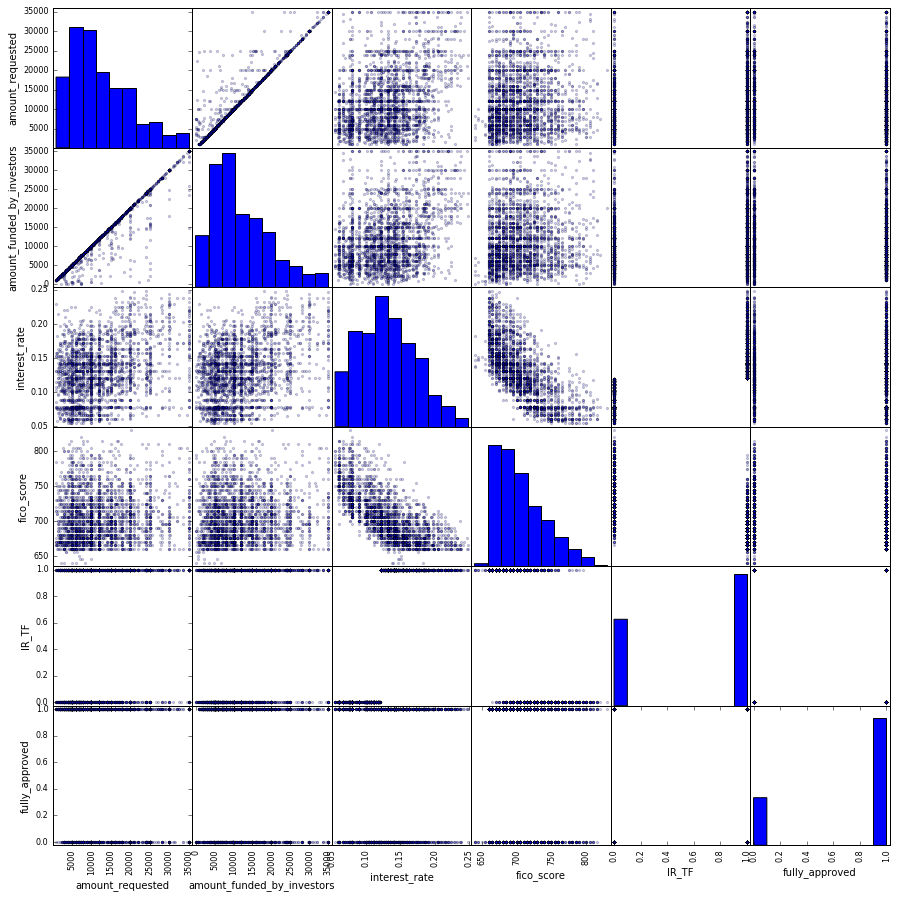

In [7]:
pd.tools.plotting.scatter_matrix(df, alpha=0.2, figsize=(15, 15));

In [8]:
df['fully_approved'].mean()

0.7272

Investors only ever fund up to the amount requested, never more. About 70% of requests are fully approved. There is a clear negative correlation between fico_score and interest_rate. In most cases, individuals receive an interest rate at or below 12%.

Step 5: Define and fit the logistic regression model.

In [9]:
model = smf.logit('IR_TF ~ amount_requested + fico_score + fully_approved', df).fit()
coeff = model.params
coeff

Optimization terminated successfully.
         Current function value: 0.319486
         Iterations 8


Intercept           60.013565
amount_requested     0.000175
fico_score          -0.087321
fully_approved       0.044832
dtype: float64

Step 6: Define a function that will take our parameters. 
  
What is the probability that the loan will be approved? 
  
Using a probability of 70% as the lower threshhold, will the loan be approved?

In [10]:
def logistic_function(w, x, y, z):
    p = (1/(1 + math.e**(w[0] + w[2]*x + w[1]*y + w[3]*z)))
    print('p = {}'.format(p))
    if p >= 0.7:
        print('\nApproved')
    else:
        print('\nDenied')

logistic_function(coeff, 750, 10000, 1)

p = 0.9755603017972749

Approved
